In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
dji_stocks = pd.read_csv('DJI.csv')

In [4]:
dji_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [5]:
data_to_use_dji = dji_stocks['Open'].values

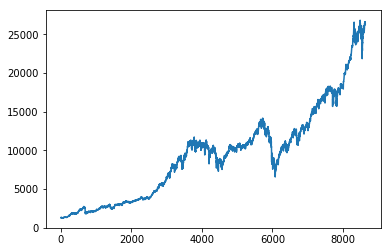

In [6]:
plt.plot(data_to_use_dji)

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [7]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

In [8]:
scaled_data_dji = scaler.fit_transform(data_to_use_dji.reshape(-1, 1))

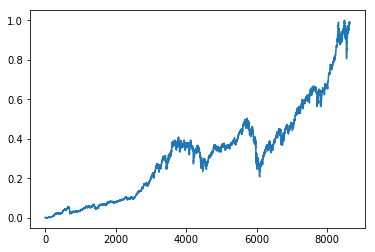

In [9]:
plt.plot(scaled_data_dji)

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [10]:
# Reconstruct data to segments using proper window size
# We use window size of 7

def window_data(data, window_size):

    X = []
    y = []
    
    i = 0
    
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    
    return X, y

In [11]:
X, y = window_data(scaled_data_dji, 10)

In [12]:
X_train  = np.array(X[:-100])
y_train = np.array(y[:-100])

X_test = np.array(X[-100:])
y_test = np.array(y[-100:])

# TesnorFlow Model

In [13]:
#Hyperparameters 

batch_size = 10 
window_size = 10 
hidden_layer = 256 
clip_margin = 4 #To prevent exploding gradient
learning_rate = 0.001 
epochs = 200

In [14]:
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])

In [15]:
# LSTM weights
#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))


Instructions for updating:
Colocations handled automatically by placer.


In [16]:
## Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


In [17]:
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    
    return state, output


In [18]:
outputs = []

for i in range(batch_size): 
    
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window feed into LSTM to get next output
    
    for ii in range(window_size):
        
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
    
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)

In [19]:
losses = []

for i in range(len(outputs)):
    
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)

Instructions for updating:
Use tf.cast instead.


In [20]:
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

# Training

In [21]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [22]:
for i in range(epochs):
    
    traind_scores = []
    
    ii = 0
    
    epoch_loss = []
    
    while(ii + batch_size) <= len(X_train):
        
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
        
    if (i % 50) == 0:
        print('Epoch {}/{}'.format(i, epochs), 'loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200 loss: 0.00030016095843166113
Epoch 50/200 loss: 6.273089093156159e-05
Epoch 100/200 loss: 3.5221983125666156e-05


KeyboardInterrupt: 

# Testing

In [25]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([outputs], feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)
    
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])
        
test_results = []
for i in range(8526):
    if i >= 8428:
        test_results.append(tests_new[i-8428])
    else:
        test_results.append(None)

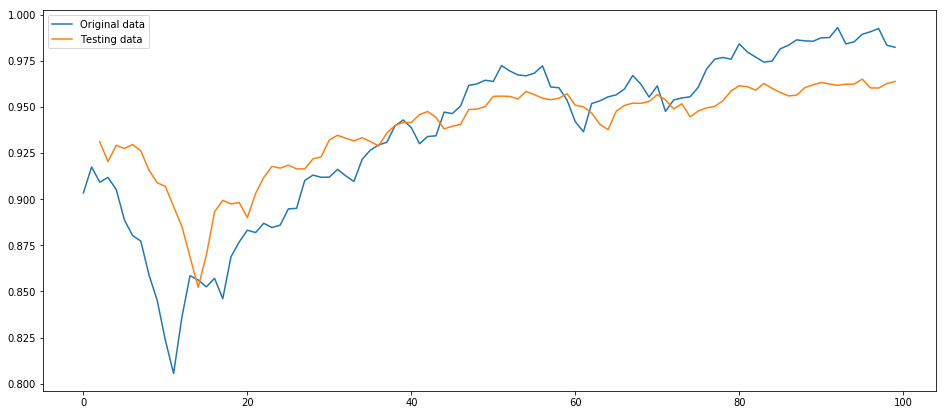

In [26]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_data_dji[-100:], label='Original data')
plt.plot(test_results[-100:], label='Testing data')
plt.legend()
plt.show()